# Diabetes Diagnosis Random Forest
Lesson 6 - Student 211039312
Danilo Carvalho Antunes
Github: Danilo-Carvalho-Antunes
Introduction
The main objetive of it is to create a model of random florests capable of predicting the diagnosis for Diabetes in woman above 21 years old.

For this Notebook I try to use Decision Trees to make the prediction and also compare with the performance of the model develop before with Neural Network from lesson 5 https://www.kaggle.com/code/dancrvlh/lesson5-danilo-carvalh-antunes-211039312
For the better visualization I try to plot some graphics and trees to understand why i chose some metrics and parameters.
This notebook is based on Jeremy Howard's FastAi course in 2022
For the sixth lesson

# Import dependecies and the Data Set

In [283]:
import numpy as np 
import pandas as pd 

In [284]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [285]:
creds=''

In [286]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [287]:
path = Path('/kaggle/input/diabetes-data-set')

In [288]:
df = pd.read_csv(path/'diabetes.csv')

# Analyzing the Data Set

In [289]:
df.shape

(768, 9)

In [290]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [291]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Here is a function to process the data to make it more regular between 0 and 1 values but after it was done I realize that after I had used the function I tried to do it again without using it and realized that it was not necessary, but it is better to leave the function in case someone wants to test and regularize the data

In [292]:
#def proc_data(df):
    #df['Pregnancies'] = df['Pregnancies']/df['Pregnancies'].max()
    #df['Glucose'] = df['Glucose']/df['Glucose'].max()
    #df['BloodPressure'] = df['BloodPressure']/df['BloodPressure'].max()
    #df['SkinThickness'] = df['SkinThickness']/df['SkinThickness'].max()
    #df['Insulin'] = df['Insulin']/df['Insulin'].max()
    #df['BMI'] = df['BMI']/df['BMI'].max()
    #df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction']/df['DiabetesPedigreeFunction'].max()
    #df['Age'] = df['Age']/df['Age'].max()

#proc_data(df)

In [293]:
#df

In [294]:
#df.describe()

In [295]:
df.mean()

Pregnancies                   3.845052
Glucose                     120.894531
BloodPressure                69.105469
SkinThickness                20.536458
Insulin                      79.799479
BMI                          31.992578
DiabetesPedigreeFunction      0.471876
Age                          33.240885
Outcome                       0.348958
dtype: float64

## Separating my data types

In [296]:
cats=[]
conts=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
dep="Outcome"

### Below there is a function that sees the relationship between a categorical column and the outcome, however as my data only has contiguous columns it was not necessary to use

In [297]:
#ForCategorical Types
#import seaborn as sns

#fig,axs = plt.subplots(1,2, figsize=(11,5))
#sns.barplot(data=df, y=dep, x="CategoricalColumn", ax=axs[0]).set(title="Diabetes")
#sns.countplot(data=df, x="CategoricalColumn", ax=axs[1]).set(title="Histogram");

# Separating training and validation data

In [298]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

### xs is for input and y is for output

In [299]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

## After finding the "heaviest" column for the Tree I try to make a prediction only with that column

In [300]:
preds = val_xs.Glucose>120

In [301]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.3020833333333333

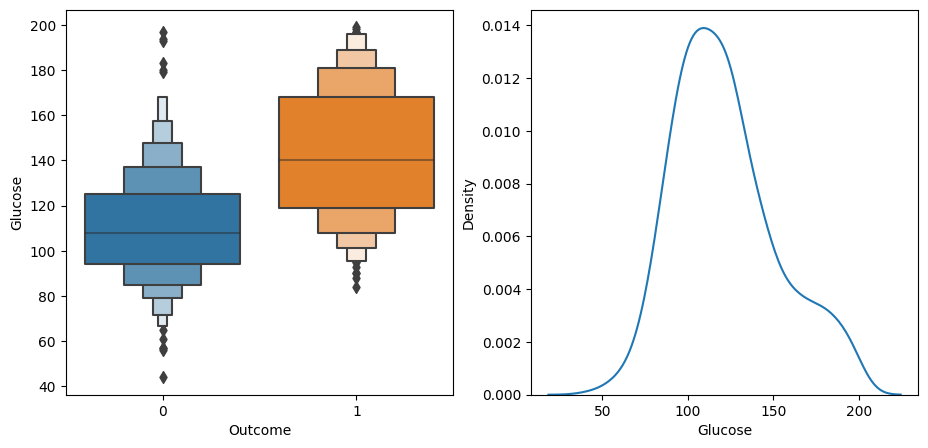

In [302]:
import seaborn as sns

df_glucose = trn_df[trn_df.Glucose>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_glucose, x=dep, y="Glucose", ax=axs[0])
sns.kdeplot(data=df_glucose, x="Glucose", ax=axs[1]);

In [303]:
preds = val_xs.Glucose>130

In [304]:
mean_absolute_error(val_y, preds)

0.2760416666666667

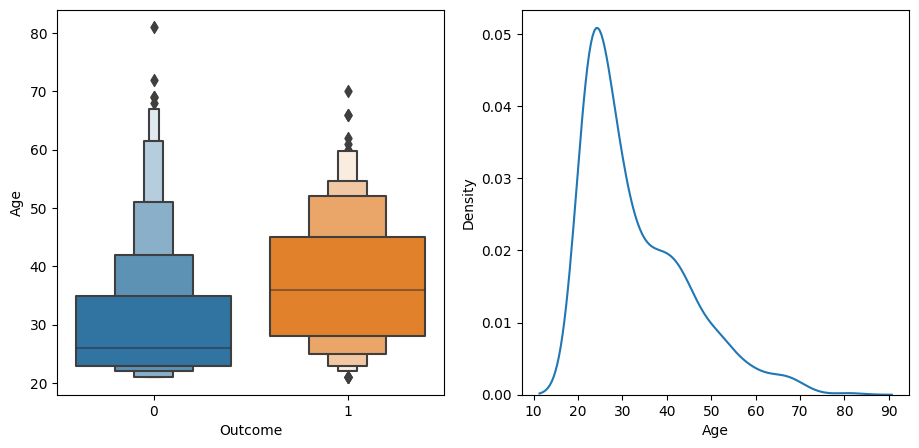

In [305]:
df_age = trn_df[trn_df.Age>0.25]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_age, x=dep, y="Age", ax=axs[0])
sns.kdeplot(data=df_age, x="Age", ax=axs[1]);

In [306]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [307]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [308]:
score(trn_xs["Glucose"], trn_y,130)

0.4312218281946582

In [309]:
score(trn_xs["Age"], trn_y,28)

0.44533603634503166

In [310]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=100)(iscore);

0.47593982792655976

In [311]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 81])

In [312]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

28

In [313]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(28, 0.44533603634503166)

In [314]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Pregnancies': (6, 0.46331859565694344),
 'Glucose': (127, 0.4260784214730209),
 'BloodPressure': (68, 0.47025946603709456),
 'SkinThickness': (31, 0.4698045177567533),
 'Insulin': (120, 0.4661863898178298),
 'BMI': (28.8, 0.44245857924729487),
 'DiabetesPedigreeFunction': (0.318, 0.46921923604380783),
 'Age': (28, 0.44533603634503166)}

# Making a Decision Tree

In [315]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

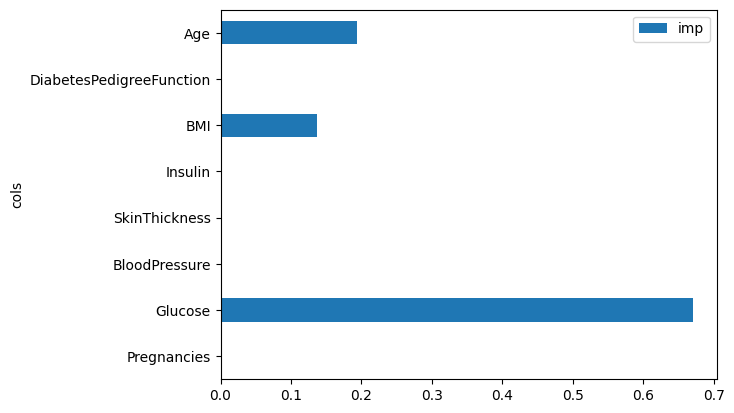

In [316]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [317]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

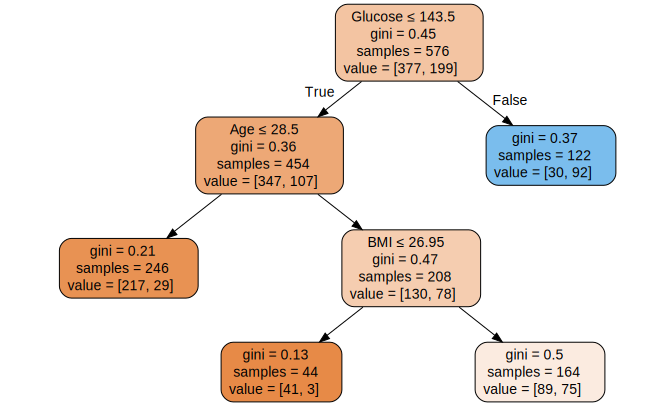

In [318]:
draw_tree(m, trn_xs, size=10)

In [319]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [320]:
def acc(probs):
    predictions = (probs > 0.5).astype(np.float32)
    return np.mean(predictions == val_y)

In [321]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2864583333333333

In [322]:
acc(m.predict(val_xs))

0.7135416666666666

# Making another Decison Tree but deeper

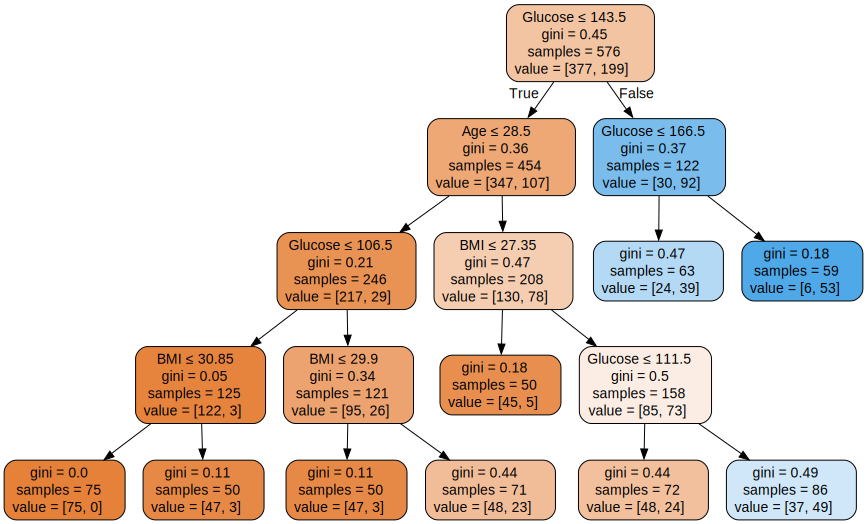

In [323]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [324]:
mean_absolute_error(val_y, m.predict(val_xs))

0.25

In [325]:
acc(m.predict(val_xs))

0.75

# Making a Random Forest

In [326]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [327]:
trees = [get_tree() for t in range(100)]

In [328]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.31197916666666664

## Making a Random Forest Using Skicit-Learn 

In [329]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
preds = rf.predict(val_xs)
mean_absolute_error(val_y, preds)

0.25

In [330]:
acc(preds)

0.75

# From the previus model about Neural Network from scrath
### Best Accuracy = 0.6275
- Linear Model lower Loss = 0.359
- Using Sigmoid lower Loss = 0.352
- Using Matrix product lower Loss =  0.352
- Using Neural Network lower Loss = 0.346
- Ussing Deep Learning lower Loss = 0.349

# Deploy HuggingFace

In [331]:
import joblib
joblib.dump(rf,'RandomForestModel.joblib')

['RandomForestModel.joblib']

https://huggingface.co/spaces/fastaioncampus/DiabetesRandomForest